In [5]:
import torch
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys

sys.path.insert(0, '..')

## Preparation

In [6]:
dataset_path = '../../tdc_datasets'
task = 'detection'
MODEL_FILEDIR = os.path.join(dataset_path, task, 'train')
EXTRACTED_DIR = './extracted_features'
NUM_MODEL = 500
model_classes = ['MNIST_Network', 'SimpleViT', 'WideResNet']
clean_or_trojan = ['clean', 'trojan']

def num_to_model_id(num):
    return 'id-' + str(10000+num)[1:]

## Feature Extraction

## Data Loading

#### Directly load without saving locally

In [23]:
from itertools import product

def load_model_params(all_features, clean_or_trojan='clean', extraction_method=extract_weight, model_filedir=MODEL_FILEDIR, add_label=True):
    for num in tqdm(range(NUM_MODEL)):
        model_filepath = os.path.join(model_filedir, clean_or_trojan, num_to_model_id(num), 'model.pt')
        with torch.no_grad():
            model = torch.load(model_filepath)
        model_class = model._get_name()
        params = extraction_method(model)
        if add_label:
            params = np.append(params, [clean_or_trojan != 'clean'], axis=0)
        all_features[model_class+'_'+clean_or_trojan].append(params)
    for k, v in all_features.items():
        if len(v) != 0:
            all_features[k] = np.stack(v, axis=0)


100%|██████████| 500/500 [00:37<00:00, 13.51it/s]


In [ ]:
weights = {mc+'_'+cot:[] for mc, cot in list(product(model_classes, clean_or_trojan))}

load_model_params(weights)
load_model_params(weights, 'trojan')

In [39]:
eigens = {mc+'_'+cot:[] for mc, cot in list(product(model_classes, clean_or_trojan))}

load_model_params(eigens, clean_or_trojan='clean', extraction_method=extract_eigen)
load_model_params(eigens, clean_or_trojan='trojan', extraction_method=extract_eigen)

100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


#### To save and load the params from directory

In [ ]:
from itertools import product

def save_model_params_npy(clean_or_trojan='clean', extraction_method=extract_weight, model_filedir=MODEL_FILEDIR, extracted_dir=EXTRACTED_DIR):
    for num in tqdm(range(NUM_MODEL)):
        model_filepath = os.path.join(model_filedir, clean_or_trojan, num_to_model_id(num), 'model.pt')
        with torch.no_grad():
            model = torch.load(model_filepath)
        model_class = model._get_name()
        params = extraction_method(model)
        potential_dir = os.path.join(extracted_dir, clean_or_trojan, model_class)
        if os.path.exists(potential_dir):
            np.save(os.path.join(potential_dir, f'{num_to_model_id(num)}.npy'), params)
        else:
            os.mkdir(potential_dir)
            np.save(os.path.join(potential_dir, f'{num_to_model_id(num)}.npy'), params)

# save_model_params_npy()
# save_model_params_npy('trojan')


def load_all_model_params(all_features, extracted_dir=EXTRACTED_DIR, add_label=True):
    for key in all_features.keys():
        c_o_t = key.split('_')[-1]
        model_class = key.replace(c_o_t, '')
        params_dir = os.path.join(extracted_dir, c_o_t, model_class)
        features = []
        for param_dir in os.listdir(params_dir):
            model_param = np.load(os.path.join(params_dir, param_dir))
            features.append(model_param)
        features = np.stack(features, axis=0)
        if add_label:
            label = c_o_t != 'clean'
            labels = np.asarray([label] * features.shape[0]).reshape((features.shape[0], 1))
            features = np.append(features, labels, axis=1)
        all_features[key] = features
    return all_features

In [40]:
mnist_weight = np.concatenate((weights['MNIST_Network_clean'], weights['MNIST_Network_trojan']), axis=0)
vit_weight = np.concatenate((weights['SimpleViT_clean'], weights['SimpleViT_trojan']), axis=0)
wrn_weight = np.concatenate((weights['WideResNet_clean'], weights['WideResNet_trojan']), axis=0)
mnist_eigen = np.concatenate((eigens['MNIST_Network_clean'], eigens['MNIST_Network_trojan']), axis=0)
vit_eigen = np.concatenate((eigens['SimpleViT_clean'], eigens['SimpleViT_trojan']), axis=0)
wrn_eigen = np.concatenate((eigens['WideResNet_clean'], eigens['WideResNet_trojan']), axis=0)

In [49]:
mnist = np.concatenate((mnist_weight[:, :-1], mnist_eigen), axis=1)
vit = np.concatenate((vit_weight[:, :-1], vit_eigen), axis=1)
wrn = np.concatenate((wrn_weight[:, :-1], wrn_eigen), axis=1)

In [41]:
mnist_weight.shape, mnist_eigen.shape, vit_weight.shape, vit_eigen.shape, wrn_weight.shape, wrn_eigen.shape

((250, 91), (250, 212), (250, 331), (250, 3164), (500, 581), (500, 2817))

## Train / Tune the Models

In [42]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [50]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.02)
X_train, X_test, y_train, y_test = train_test_split(vit[:, :-1], vit[:, -1], test_size=.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.66

In [214]:
result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_accuracy', 'rank_test_neg_log_loss'])

## Feeding Random Noise

In [105]:
import torch
import torchvision.transforms as T

def random_noise_generator(channel, resolution, num_of_datapts=1000, generate_method='random_tensor', noise_level=1, input_data=None):
    random_noise = None
    if generate_method == 'random_tensor':
        random_noise = torch.rand(num_of_datapts, channel, resolution, resolution)
    elif generate_method == 'gaussian_blur':
        blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        # blurrer = T.GaussianBlur(kernel_size=resolution-1)
        if input_data is None:
            # input_data = torch.zeros(num_of_datapts, channel, resolution, resolution)
            # input_data = torch.rand(num_of_datapts, channel, resolution, resolution)
            input_data = torch.randint(0, 256, (num_of_datapts, channel, resolution, resolution)).type(torch.float)
        rnd_idx = np.random.permutation(num_of_datapts)[:num_of_datapts*noise_level]
        random_noise = input_data
        random_noise[rnd_idx, :] = blurrer(input_data[rnd_idx, :])
    return random_noise

In [106]:
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def extract_info_for_model_input(clean_or_trojan, model_id):
    curr_model_dir = os.path.join(MODEL_FILEDIR, clean_or_trojan, num_to_model_id(model_id))
    with open(os.path.join(curr_model_dir, 'info.json'), 'r') as f:
        curr_model_info = json.load(f)
        resolution = curr_model_info['input_resolution']
        channel = 1 if curr_model_info['dataset'] == 'MNIST' else 3
    return channel, resolution

def extract_prob_from_models(clean_or_trojan, model_id, random_noise):
    curr_model_dir = os.path.join(MODEL_FILEDIR, clean_or_trojan, num_to_model_id(model_id))
    with torch.no_grad():
        curr_model = torch.load(os.path.join(curr_model_dir, 'model.pt')).to(device)
        random_noise = random_noise.to(device)
        output = curr_model(random_noise).softmax(dim=-1).mean(dim=0)
    return output.cpu().detach().numpy()

In [114]:
model_nums = range(0, 500)
iters = 1
cleans_model_avgs, trojan_model_avgs = [], []
for model_num in tqdm(model_nums):
    clean_outputs, trojan_outputs = [], []
    for _ in range(iters):
        cha_c, res_c = extract_info_for_model_input('clean', model_num)
        cha_t, res_t = extract_info_for_model_input('trojan', model_num)
        random_noise_c = random_noise_generator(cha_c, res_c, generate_method='gaussian_blur', num_of_datapts=5000)
        random_noise_t = random_noise_generator(cha_t, res_t, generate_method='gaussian_blur', num_of_datapts=5000)
        clean_outputs.append(extract_prob_from_models('clean', model_num, random_noise_c))
        trojan_outputs.append(extract_prob_from_models('trojan', model_num, random_noise_t))
    clean_avg = np.stack(clean_outputs, axis=0).mean(axis=0)
    trojan_avg = np.stack(trojan_outputs, axis=0).mean(axis=0)
    cleans_model_avgs.append(clean_avg)
    trojan_model_avgs.append(trojan_avg)

100%|██████████| 500/500 [13:45<00:00,  1.65s/it]


In [131]:
model_sep = [0, 125, 250, 375, 500]
clean_avgs, trojan_avgs = [], []
for i in range(4):
    clean_avgs.append(np.stack(cleans_model_avgs[model_sep[i]: model_sep[i+1]], axis=0).mean(axis=0))
    trojan_avgs.append(np.stack(trojan_model_avgs[model_sep[i]: model_sep[i+1]], axis=0).mean(axis=0))

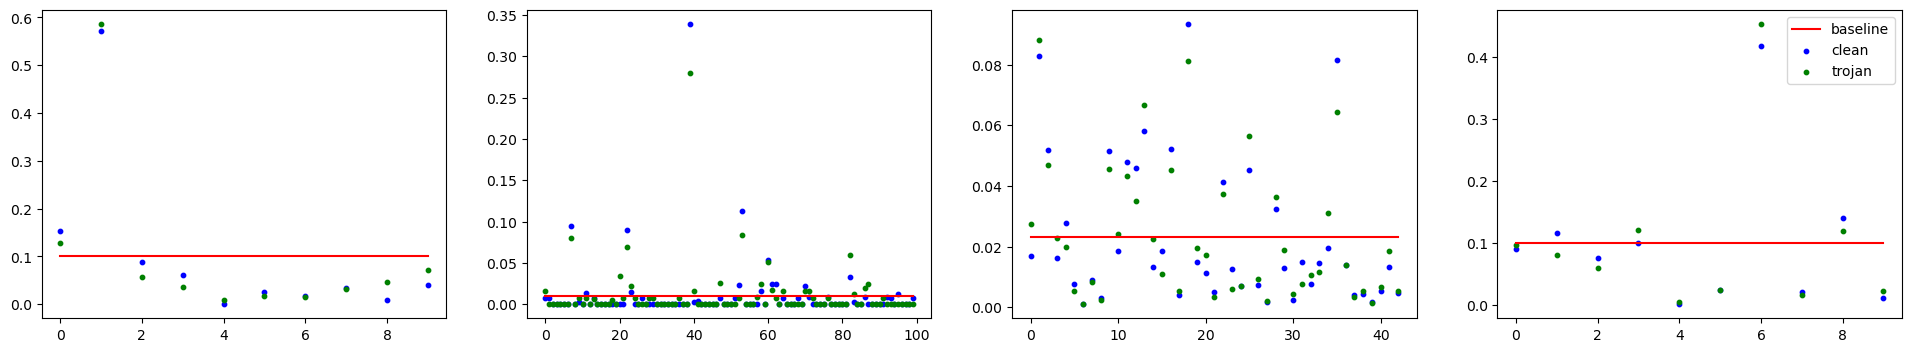

In [135]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(24, 4))

for ind, ax in enumerate(axs):
    clean_avg = clean_avgs[ind]
    trojan_avg = trojan_avgs[ind]
    num_classes = clean_avg.shape[0]
    baseline = [1/num_classes]*num_classes
    xlabel = list(range(num_classes))
    ax.plot(xlabel, baseline, c='red', label='baseline')
    ax.scatter(xlabel, clean_avg, c='blue', label='clean', s=10)
    ax.scatter(xlabel, trojan_avg, c='green', label='trojan', s=10)

plt.legend()
plt.show()

# Submission

In [210]:
with open(os.path.join('mntd_submission', 'predictions.npy'), 'wb') as f:
    np.save(f, np.array(scores))
    
!cd mntd_submission && zip ../mntd_submission.zip ./* && cd ..

13998.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  adding: predictions.npy (deflated 45%)


In [211]:
pred = np.load(os.path.join('mntd_submission', 'predictions.npy'))

array([0.06724423, 0.69379105, 0.06724423, 0.37470518, 0.06968193])